In [1]:
# ! pip install torch transformers datasets tqdm
# ! pip install lxml

In [ ]:
import torch, glob
from torch.utils.data import IterableDataset, DataLoader
from transformers import GPT2LMHeadModel
import time 

class PTIterableDataset(IterableDataset):
    def __init__(self, pt_files):
        self.pt_files = pt_files

    def __iter__(self):
        for file_path in self.pt_files:
            data = torch.load(file_path)
            for i in range(data["input_ids"].size(0)):
                sample = {
                    "input_ids": data["input_ids"][i],
                    "attention_mask": data["attention_mask"][i],
                    "files": file_path.split('/')[-1]
                }
                if data.get("labels") is not None:
                    sample["labels"] = data["labels"][i]
                yield sample


# torch.cuda.empty_cache()

batch_size = 16
train_files = sorted(glob.glob("../processed_batches/train/*.pt"))
test_files = sorted(glob.glob("../processed_batches/test/*.pt"))

train_loader = DataLoader(PTIterableDataset(train_files), batch_size=batch_size, num_workers=0)
# test_loader = DataLoader(PTIterableDataset(test_files), batch_size=batch_size, num_workers=8)

print('-'*50 + 'TRAIN' + '-'*50)
train = next(iter(train_loader))
print(train)
print(train['input_ids'].shape)

# print('-'*50 + 'TEST' + '-'*50)
# test = next(iter(test_loader))
# print(test)
# print(test['input_ids'].shape)

/Users/collinswestnedge/Desktop/programming/git_hub/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------------------------------------------------TRAIN--------------------------------------------------
{'input_ids': tensor([[ 1925,  5889,   286,  ...,   274,  2983,  3421],
        [  739,  4096,  3403,  ...,   349,   415, 39422],
        [  357,    57,  3535,  ..., 10280,    13,   317],
        ...,
        [ 3060,   653,   286,  ...,  2785,  7016,  1575],
        [  284,   262,  5827,  ...,     8,   290,   362],
        [   79,     7,    88,  ...,   286, 10897,    12]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'files': ['batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt', 'batch_0000.pt'

In [3]:
train.keys()

dict_keys(['input_ids', 'attention_mask', 'files'])

In [4]:
model = torch.compile(GPT2LMHeadModel.from_pretrained("openai-community/gpt2"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4, # 1e-4 for 16x16 # maybe 8e-5 for 1024
    )

gradient_accumulation_steps = 1
num_epochs = 1
global_step = 0

In [5]:
batch_size * gradient_accumulation_steps

16

### Login to hub to save off model

In [6]:
from huggingface_hub import HfApi
import getpass
import os 

hf_token = getpass.getpass("Enter your Hugging Face token: ")
os.environ["HF_TOKEN"] = hf_token
repo_name  = "cwestnedge/gpt2_pubmed_abstracts"
api = HfApi(token=os.environ["HF_TOKEN"])

In [ ]:
def save_checkpoint_metadata(optimizer, step, losses, batch_file, scaler=None):
    checkpoint = {
        'optimizer': optimizer.state_dict(),
        'global_step': step,
        'losses': losses,
        'batch_file': batch_file,
    }

    if scaler is not None:
        checkpoint['scaler'] = scaler.state_dict()

    # checkpoint file locally so we can easily push to hub
    torch.save(checkpoint, "training_state.pt")


def push_model_and_state_to_hub(model, api, step, max_retries=3, retry_delay=10):
    for attempt in range(1, max_retries+1):
        try:
            # FIRST push model to hub FIRST (creates repo if it doesnt exit)
            model.push_to_hub(repo_name, commit_message=f"Checkpoint at step {step}")

            # THEN the training state file
            api.upload_file(
                path_or_fileobj="training_state.pt",
                path_in_repo="training_state.pt",
                repo_id=repo_name,
                commit_message=f"Training state at step {step}"
            )
            # then push the model
        except Exception as e:
            print(f"Attempt {attempt} failed: {e}")
            if attempt == max_retries:
                print("Max attempts reached. Exiting.")
                raise e
            time.sleep(retry_delay)

### CPU Implementation (for testing do not recommend)

In [ ]:
losses = []
for step, batch in enumerate(train_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    batch_file_names = set(batch['files'])

    # forward pass on CPU (no autocast)
    # labels and input are same since GPT2LMHeadModel will perform shift internally 
    # if computing loss externally you will want to shift labels and pass to lossfn
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = outputs.loss

    # Apply gradient accumulation
    loss = loss / gradient_accumulation_steps
    loss.backward()

    if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1

        loss_to_log = loss.item() * gradient_accumulation_steps
        losses.append(loss_to_log)
        print(f"Global step {global_step}, loss: {loss_to_log:.4f}")

        if global_step % 100 == 0:
            save_checkpoint_metadata(
                optimizer=optimizer, 
                step=global_step, 
                losses=losses, 
                batch_file=batch_file_names
            )

            print('Pushing to hub...')
            push_model_and_state_to_hub(
                model=model, 
                api=api, 
                step=global_step, 
                max_retries=3, 
                retry_delay=10
            )

if (step + 1) % gradient_accumulation_steps != 0:
    # perform a final optimizer step to flush any remaining gradients
    optimizer.step()
    optimizer.zero_grad()
    global_step += 1
    print(f"Performed final optimizer step to flush remaining gradients at global step {global_step}")

# final commit 
print(f'FIRST PASS COMPLETE AT STEP {step}')
save_checkpoint_metadata(
    optimizer=optimizer, 
    step=global_step, 
    losses=losses, 
    batch_file=batch_file_names
)

push_model_and_state_to_hub(
    model=model, 
    api=api, 
    step=global_step, 
    max_retries=3, 
    retry_delay=10
)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Global step 1, loss: 3.5235
Pushing to hub...


model.safetensors: 100%|██████████| 498M/498M [00:16<00:00, 30.0MB/s] 
training_state.pt: 100%|██████████| 996M/996M [00:39<00:00, 25.1MB/s] 


pushes completed!


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


pushes completed!


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


pushes completed!
FIRST PASS COMPLETE AT STEP 0


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


pushes completed!


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


pushes completed!


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


pushes completed!


### GPU Implementation

In [ ]:
losses = []
scaler = torch.amp.GradScaler("cuda")

for step, batch in enumerate(train_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    batch_file_names = set(batch['files'])

    # for GPU
    with torch.autocast(device_type="cuda"):
        # labels and input are same since GPT2LMHeadModel will perform shift internally 
        # if computing loss externally you will want to shift labels and pass to lossfn
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

    loss = loss / gradient_accumulation_steps
    scaler.scale(loss).backward()

    if (step + 1) % gradient_accumulation_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        global_step += 1

        loss_to_log = loss.item() * gradient_accumulation_steps
        losses.append(loss_to_log)
        print(f"Global step {global_step}, loss: {loss_to_log:.4f}")

        if global_step % 100 == 0:
            commit_msg = f"Checkpoint at step {global_step}"
            save_checkpoint_metadata(
                optimizer=optimizer, 
                scaler=scaler,
                step=global_step, 
                losses=losses, 
                batch_file=batch_file_names
            )
            
            print('Pushing to hub...')
            push_model_and_state_to_hub(
                model=model, 
                api=api, 
                step=global_step, 
                max_retries=3, 
                retry_delay=10
            )

if (step + 1) % gradient_accumulation_steps != 0:
    # Perform a final optimizer step to flush any remaining gradients
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    global_step += 1
    print(f"Performed final optimizer step to flush remaining gradients at global step {global_step}")
    
# final commit 
print(f'FIRST PASS COMPLETE AT STEP {step}')
save_checkpoint_metadata(
    optimizer=optimizer, 
    scaler=scaler,
    step=global_step, 
    losses=losses, 
    batch_file=batch_file_names
)

push_model_and_state_to_hub(
    model=model, 
    api=api, 
    step=global_step, 
    max_retries=3, 
    retry_delay=10
)

### ------------ Load Model From Checkpoint (HF-Hub) ------------

In [54]:
# from huggingface_hub import hf_hub_download
# from transformers import AutoModelForCausalLM

# training_state_path = hf_hub_download(
#     repo_id="cwestnedge/gpt2_pubmed_abstracts", 
#     filename="training_state.pt",
#     token=hf_token
# )

# # Load the checkpoint
# checkpoint = torch.load(training_state_path, map_location=torch.device('cpu'))

# optimizer.load_state_dict(checkpoint['optimizer'])
# global_step = checkpoint['global_step']
# # scaler.load_state_dict(checkpoint['scaler']) # this will be for GPU only
# loss = checkpoint['losses']
# last_batch = checkpoint['batch_file']

# model = AutoModelForCausalLM.from_pretrained(repo_name, token=hf_token)
# model.to(device);

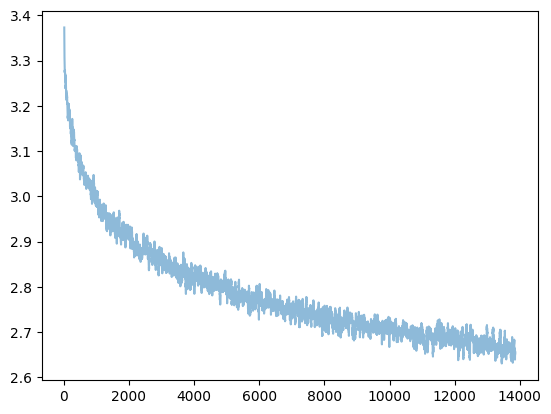

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# a = pd.Series(loss).rolling(20).mean()
# plt.plot(a, alpha=.5)